In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image, label

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = MNISTDataset('/kaggle/input/digit-recognizer/train.csv', transform=transform, is_test=False)
test_dataset = MNISTDataset('/kaggle/input/digit-recognizer/test.csv', transform=transform, is_test=True)

In [5]:
print("Train Size: " + str(len(train_dataset)) + "\nTest Size: " + str(len(test_dataset)))

Train Size: 42000
Test Size: 28000


In [6]:
batch_size = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
for X in test_dataloader:
    print(X.shape)

    break

torch.Size([32, 1, 28, 28])


In [8]:
# Make a neural network
class Recognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 10)

        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.ReLU(x)
        x = self.layer2(x)

        return(x)
        
model = Recognizer()

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (images, labels) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.339906  [   32/42000]
loss: 0.474892  [ 3232/42000]
loss: 0.705044  [ 6432/42000]
loss: 0.393331  [ 9632/42000]
loss: 0.298622  [12832/42000]
loss: 0.626740  [16032/42000]
loss: 0.332644  [19232/42000]
loss: 0.463358  [22432/42000]
loss: 0.325841  [25632/42000]
loss: 0.388656  [28832/42000]
loss: 0.347906  [32032/42000]
loss: 0.297977  [35232/42000]
loss: 0.209939  [38432/42000]
loss: 0.307851  [41632/42000]
Epoch 2
-------------------------------
loss: 0.275830  [   32/42000]
loss: 0.098438  [ 3232/42000]
loss: 0.411361  [ 6432/42000]
loss: 0.380210  [ 9632/42000]
loss: 0.034344  [12832/42000]
loss: 0.359057  [16032/42000]
loss: 0.279619  [19232/42000]
loss: 0.122699  [22432/42000]
loss: 0.026759  [25632/42000]
loss: 0.209299  [28832/42000]
loss: 0.102809  [32032/42000]
loss: 0.101615  [35232/42000]
loss: 0.249145  [38432/42000]
loss: 0.153620  [41632/42000]
Epoch 3
-------------------------------
loss: 0.230282  [   32/42000]
loss: 0.12

In [11]:
model.eval()
predictions = []

with torch.no_grad():
    for images in test_dataloader:
        pred = model(images)
        _, predicted = torch.max(pred.data, 1)
        predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId" : range(1, len(predictions) + 1),
    "Label" : predictions
})

submission.to_csv('predictions5-7-2025.csv', index=False)

Hmmmm i think it is 0


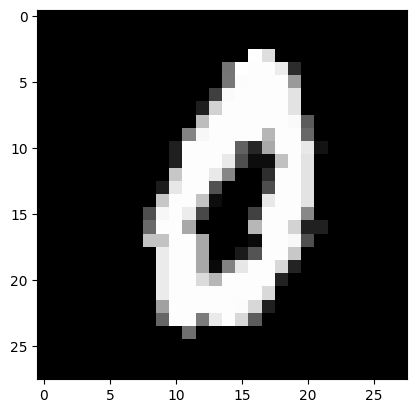

In [12]:
import random
answers = pd.read_csv('/kaggle/input/predictions-best-guesses/predictions5-7-2025.csv')
answers = answers['Label'].tolist()

index = random.randint(0, 1000)
img = test_dataset[index].reshape(28,28)
plt.imshow(img, cmap="gray")
print(f"Hmmmm i think it is {answers[index]}")